In [2]:
import boto3
import sagemaker

original_boto3_version = boto3.__version__
%pip install 'boto3>1.17.21'

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sagemaker.session import Session

region = boto3.Session().region_name

boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
# You can modify the following to use a bucket of your choosing
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = "sagemaker-featurestore-bankchurn"

print(default_s3_bucket_name)

sagemaker-us-east-1-994366592132


In [5]:
from sagemaker import get_execution_role

# You can modify the following to use a role of your choosing. See the documentation for how to create this.
role = get_execution_role()
print(role)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
arn:aws:iam::994366592132:role/LabRole


In [6]:
conda install -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 24.1.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import shap

import warnings
warnings.filterwarnings("ignore")

from colorama import Style, Fore
from sklearn.preprocessing import StandardScaler, LabelEncoder
import missingno as msno
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [8]:
# Load the original data
data  = pd.read_csv('/root/aai540-finalproject/Churn_Modelling.xls')

# Rename columns for clarity, 
data.columns = ['RowNumber', 'CustomerID', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
                          'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']



In [9]:
# Create a new feature 'CreditPerAge' representing credit score per age
data['CreditPerAge'] = data['CreditScore'] / data['Age']

# Create a new feature 'BalanceToSalaryRatio' representing the ratio of balance to estimated salary
data['BalanceToSalaryRatio'] = data['Balance'] / data['EstimatedSalary']

In [10]:
data.head()

RowNumber  CustomerID   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  CreditPerAge  BalanceToSalaryRatio  
0        101348.88       1     14.738095              0.000000  
1        112542.58       0     14.829268              0.744677  
2        113931.57       1     11.952381              1.401375  
3         93826.63       0     17.923077              0.000000  
4         79084.10       0     19.767442              1.587055

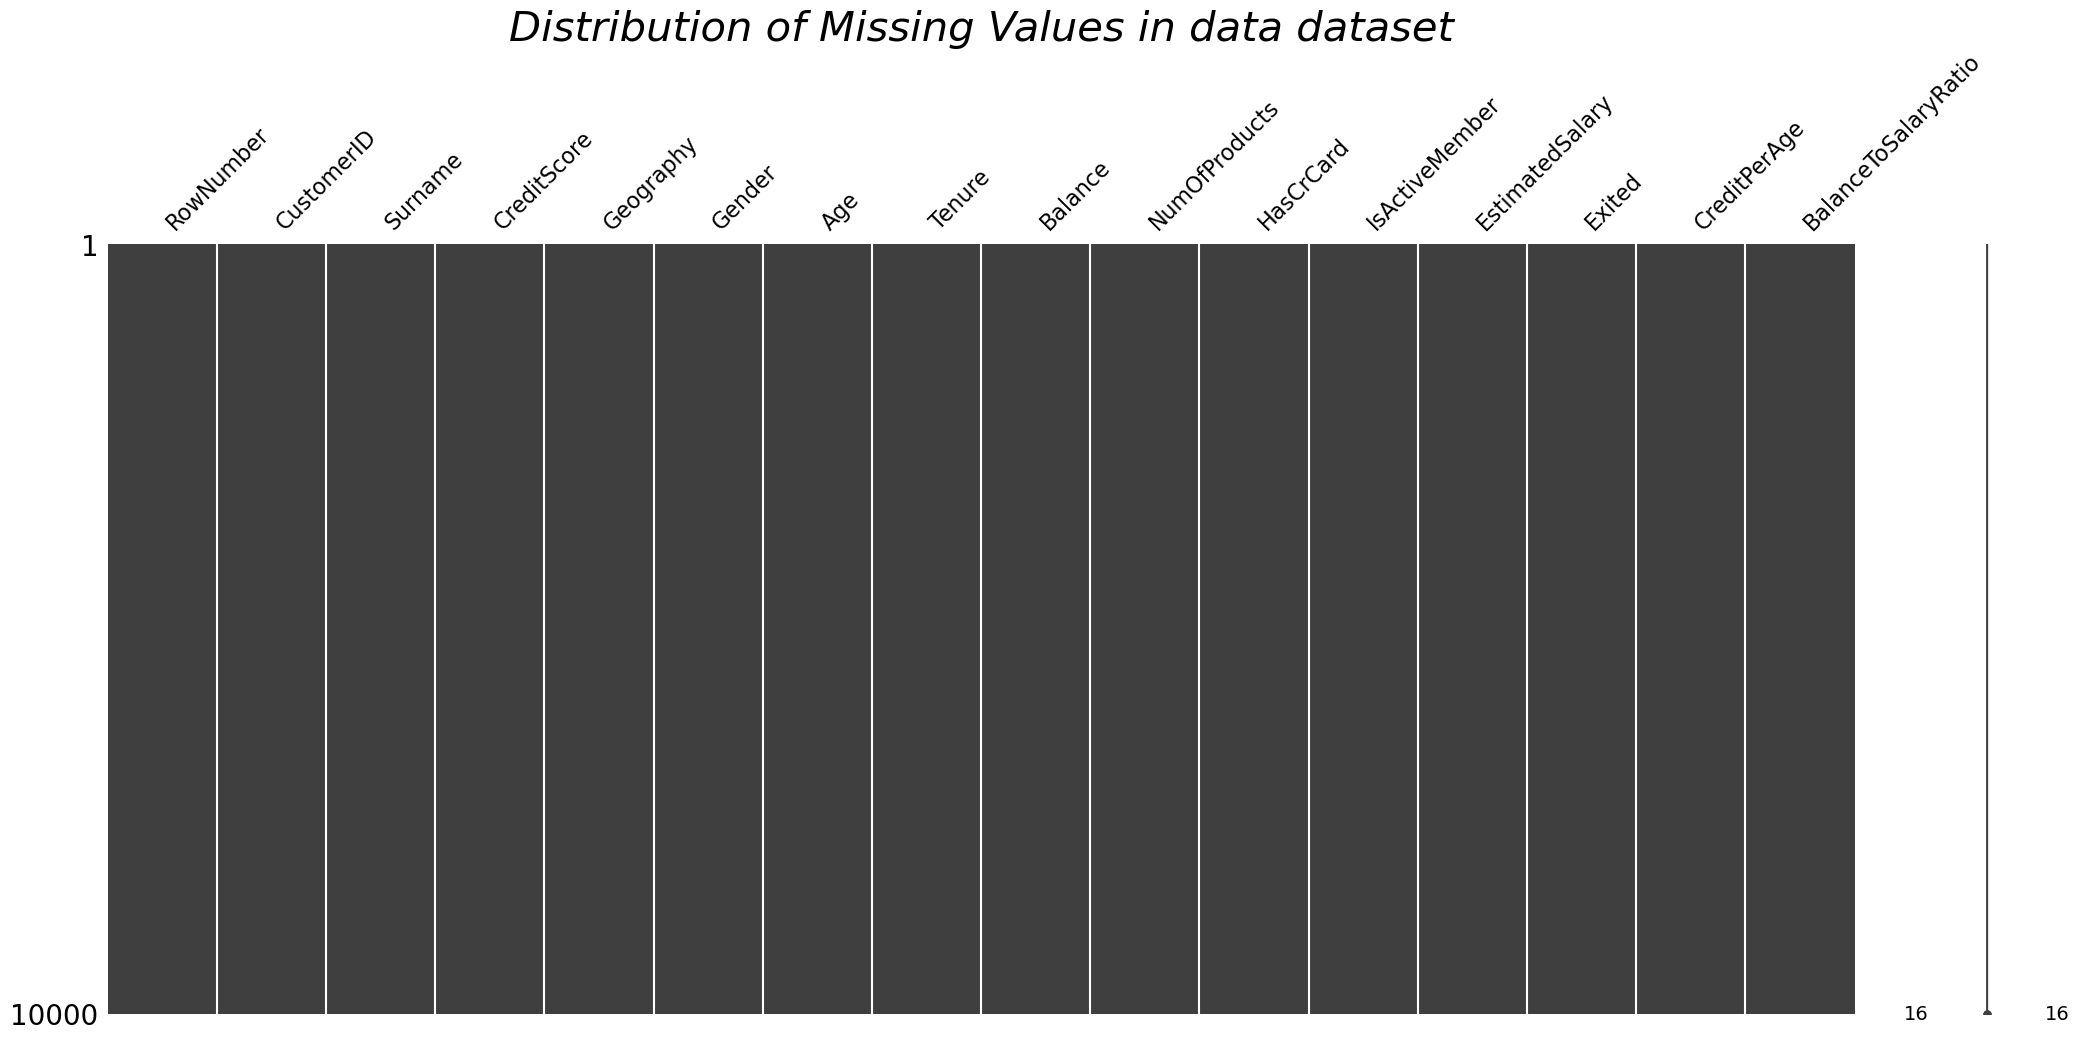

In [11]:
# Explore missing values
def plot_missing_values(df, dataset_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {dataset_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()

plot_missing_values(data, "data")

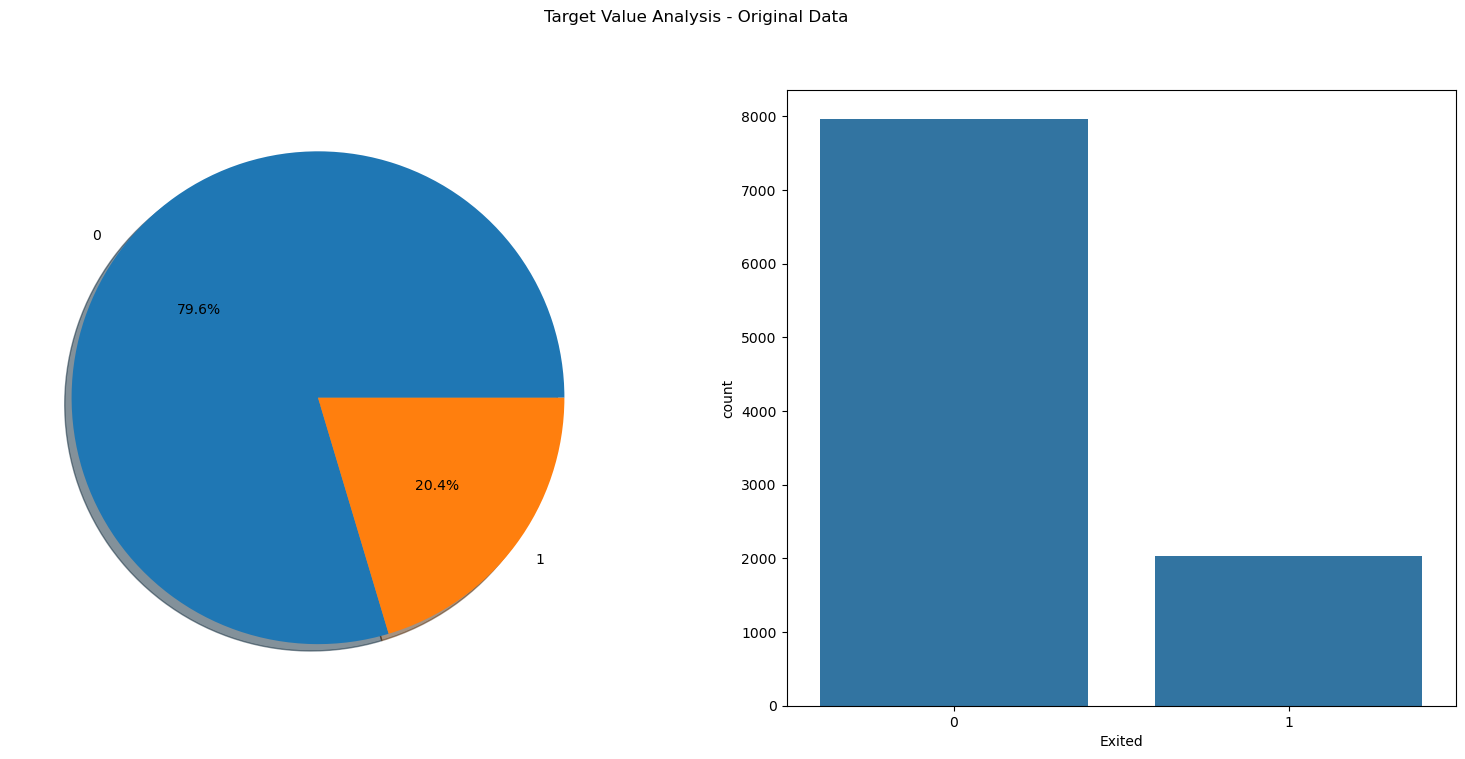

In [12]:
# Visualize target distribution for original data
f, ax = plt.subplots(1, 2, figsize=(19, 8))
data['Exited'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_ylabel('')
sns.countplot(x='Exited', data=data, ax=ax[1])
plt.suptitle('Target Value Analysis - Original Data')
plt.show()

In [13]:
# Unique value counts for each column
unique_counts = data.nunique()
threshold = 12

continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()


In [14]:
# Removing the 'Exited' from categorical since it's our target variable
if 'Exited' in categorical_vars:
    categorical_vars.remove('Exited')
if 'CustomerID' in continuous_vars:
    continuous_vars.remove('CustomerID')


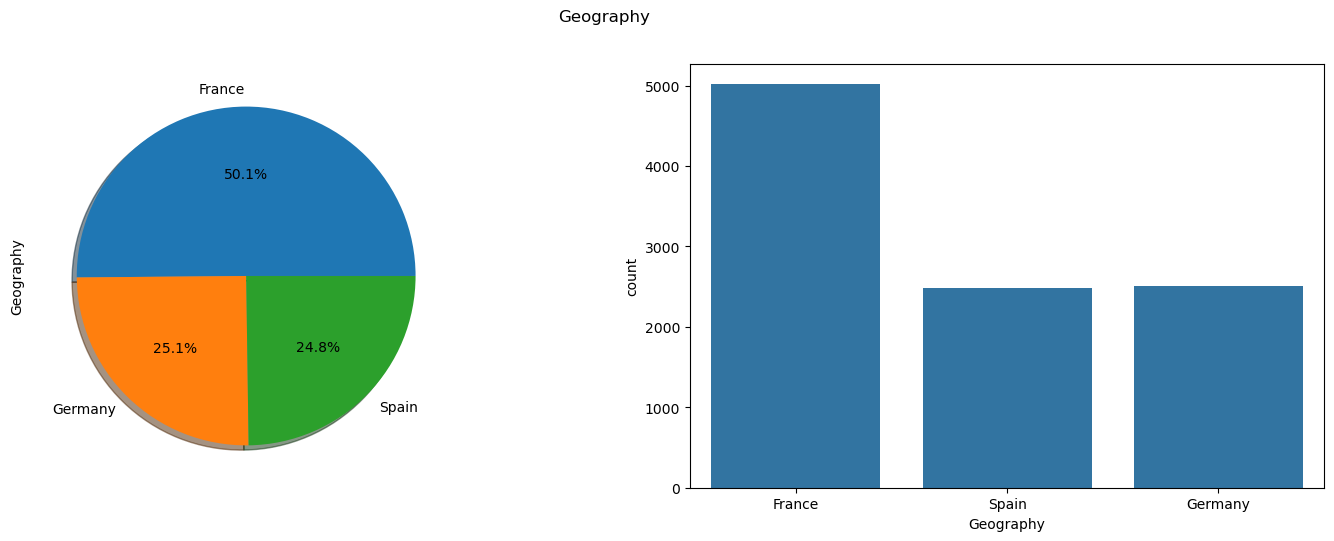

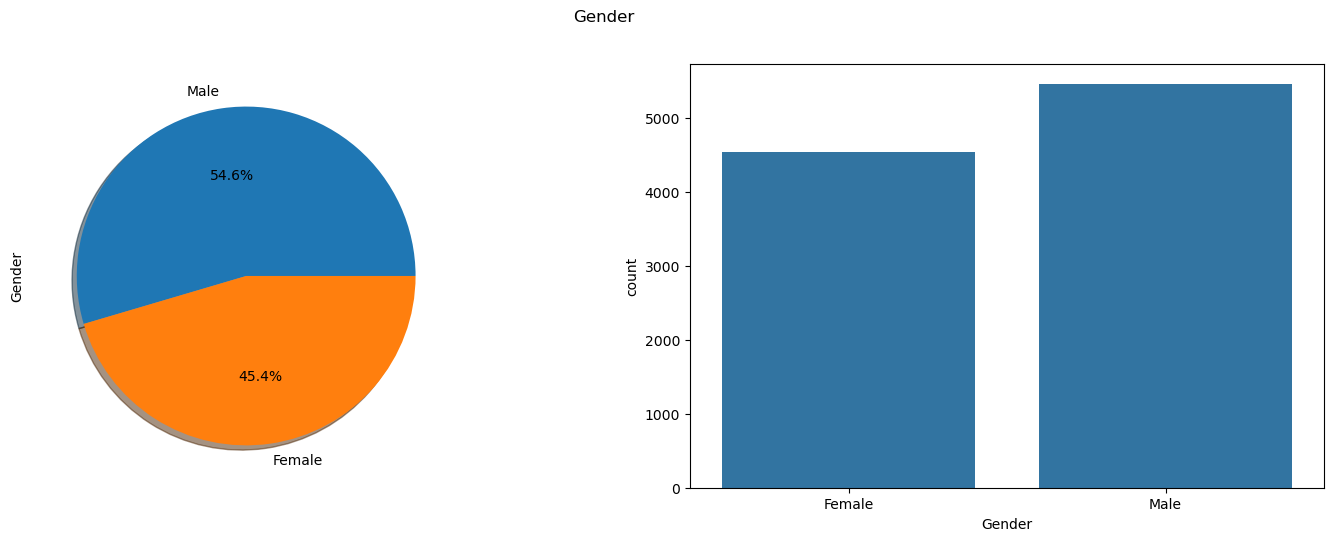

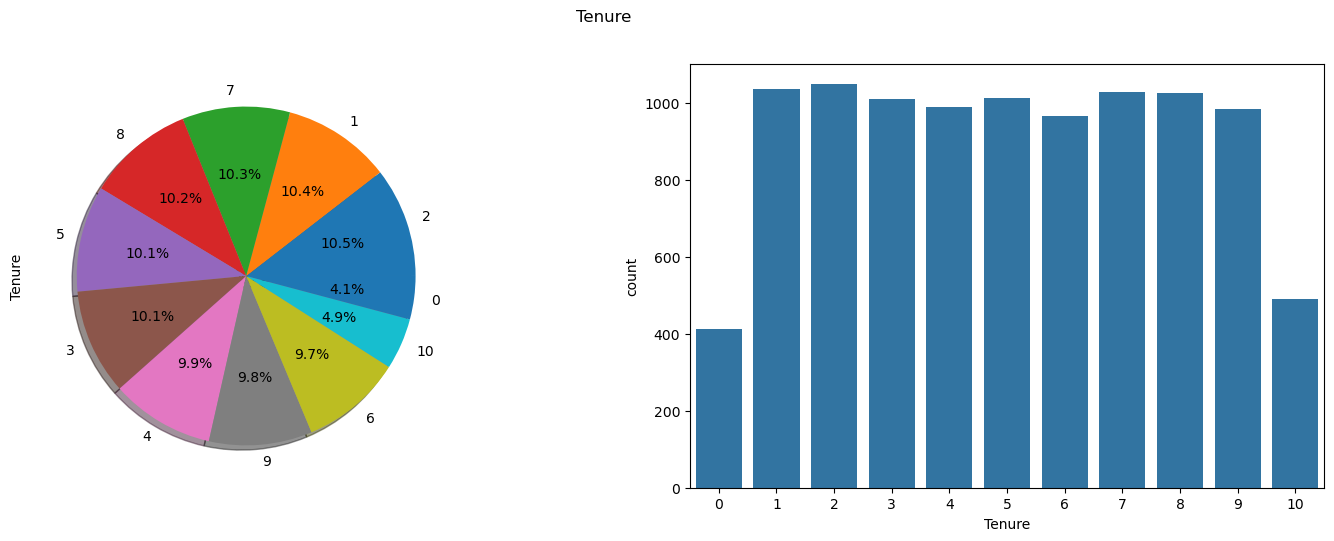

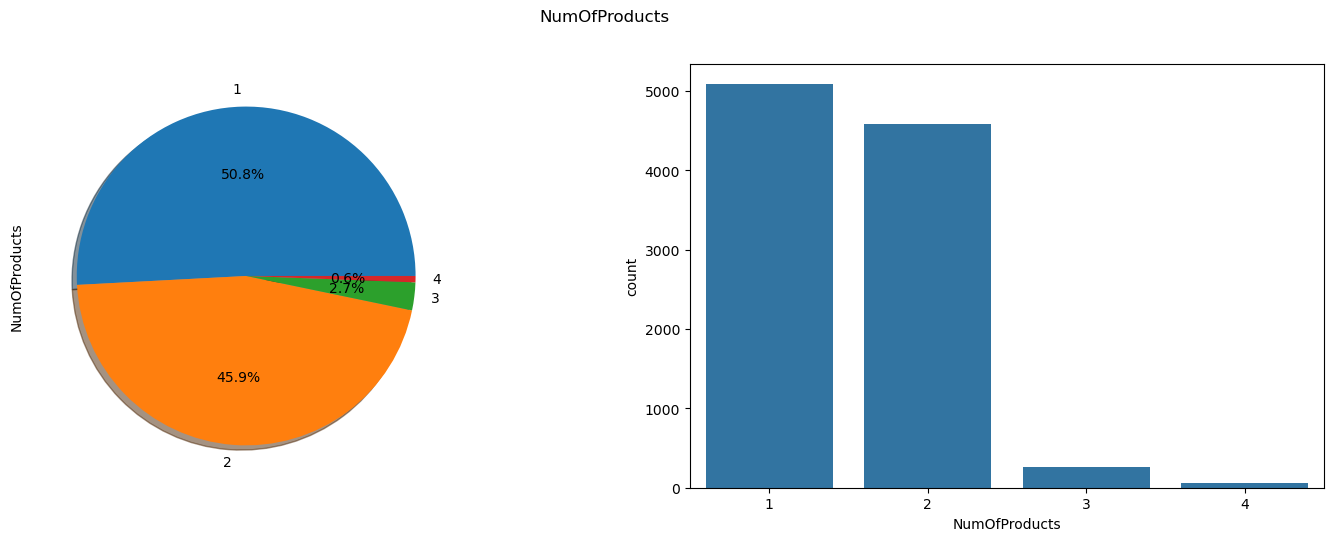

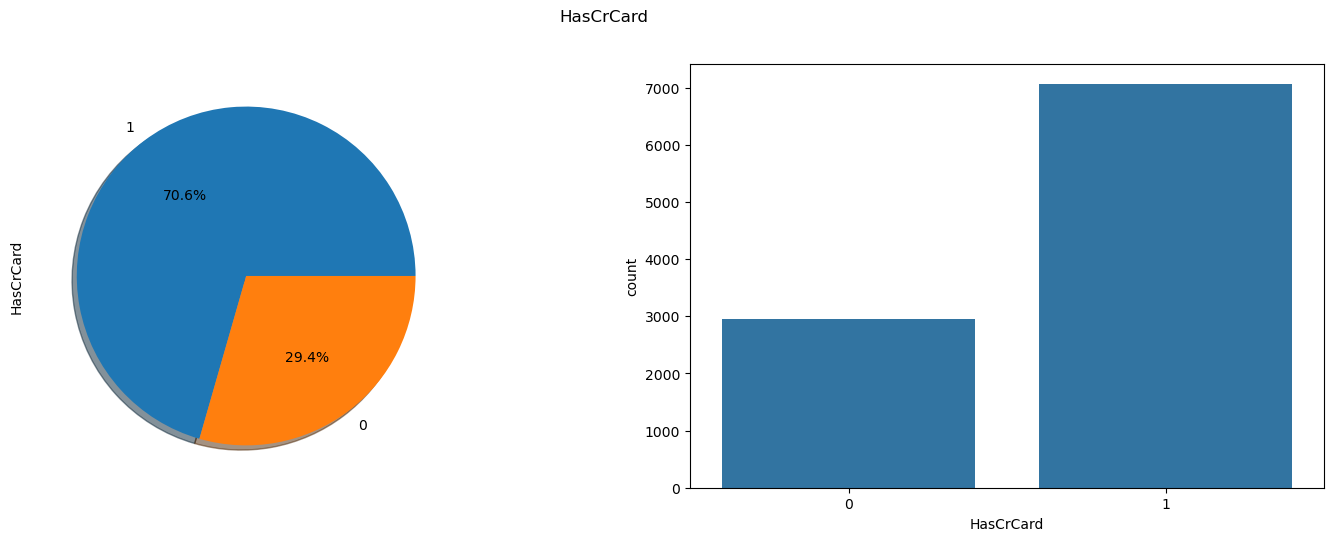

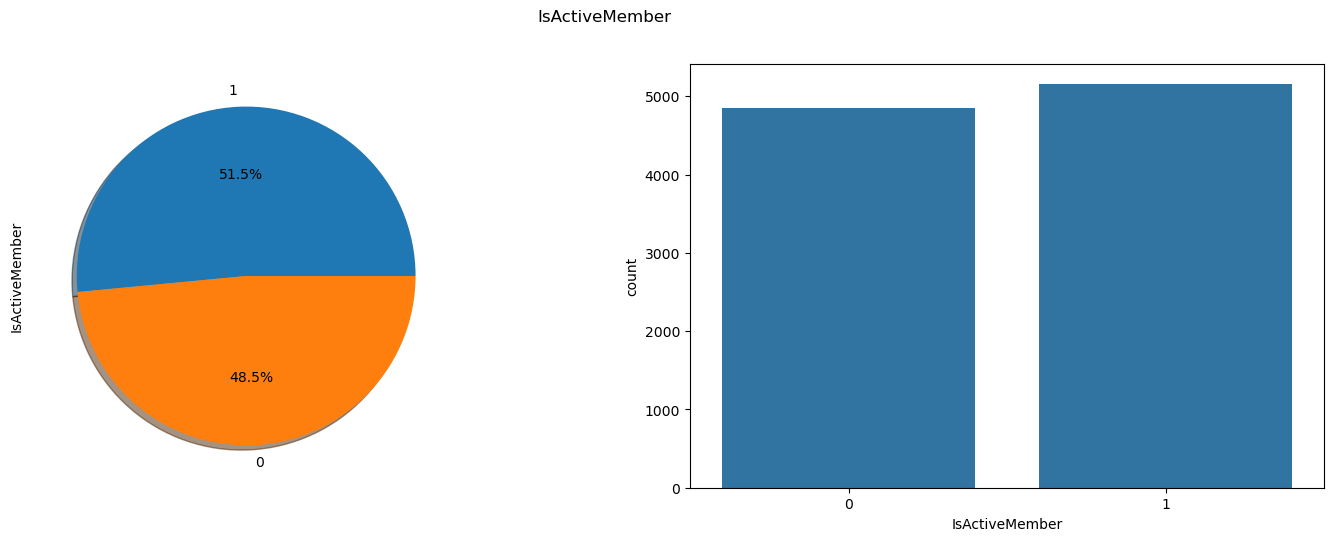

In [15]:
# Visualize categorical variables
for column in categorical_vars:
    f, ax = plt.subplots(1, 2, figsize=(18, 5.5))
    data[column].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x=column, data=data, ax=ax[1])
    plt.suptitle(f'{column}')
    plt.show()

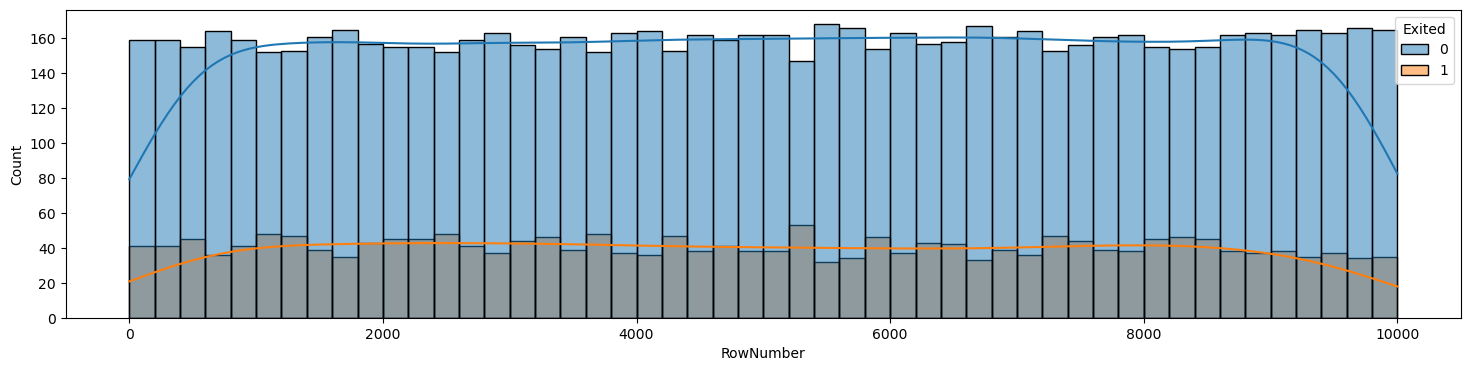

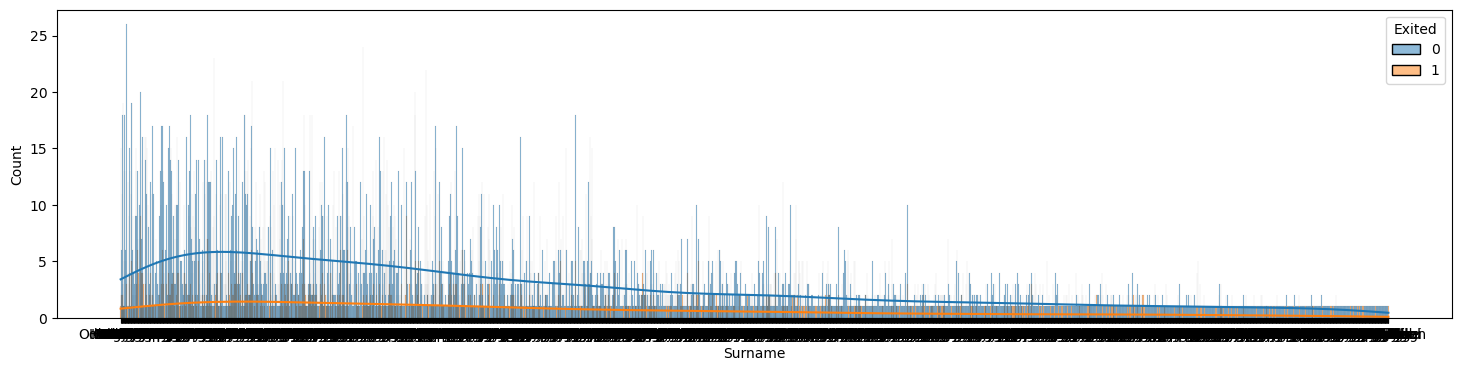

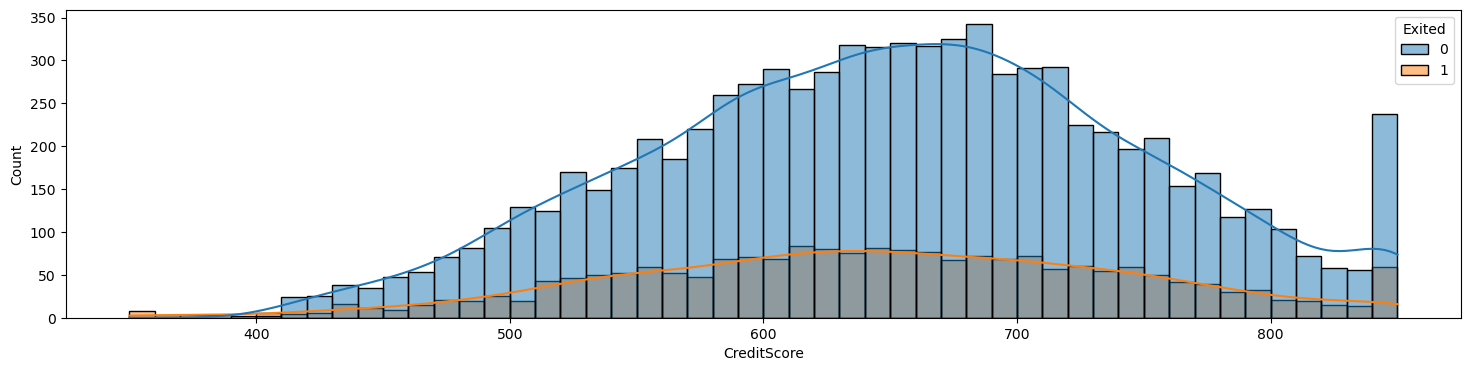

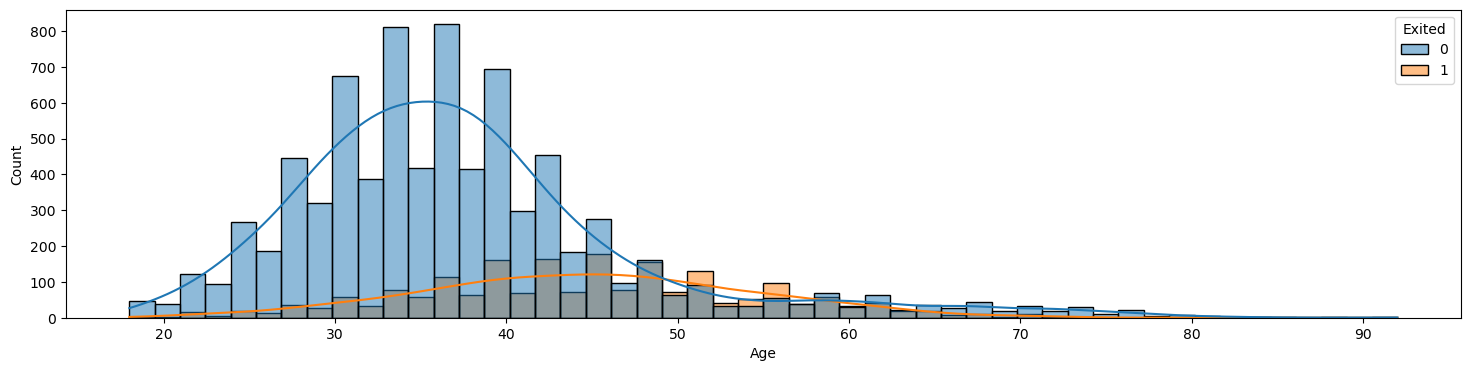

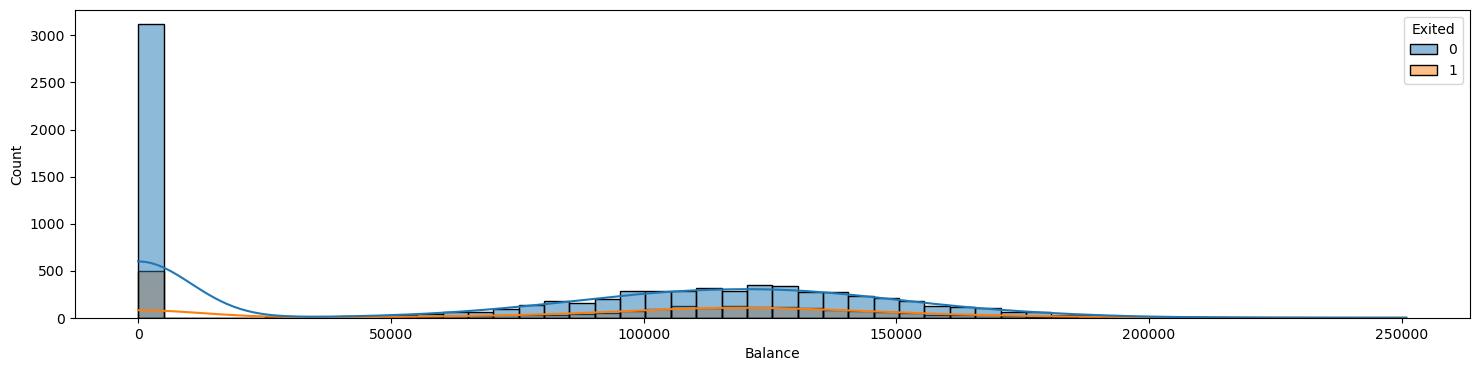

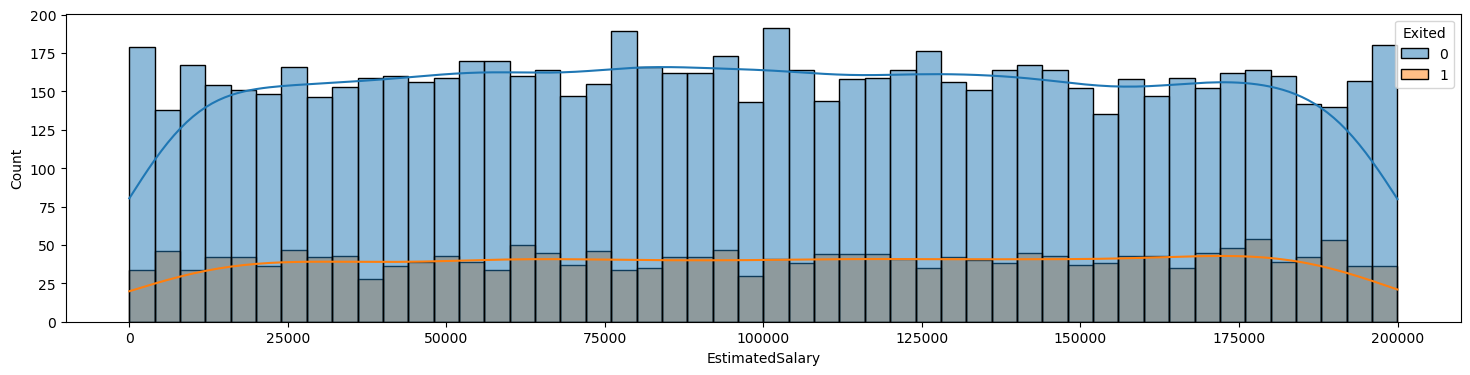

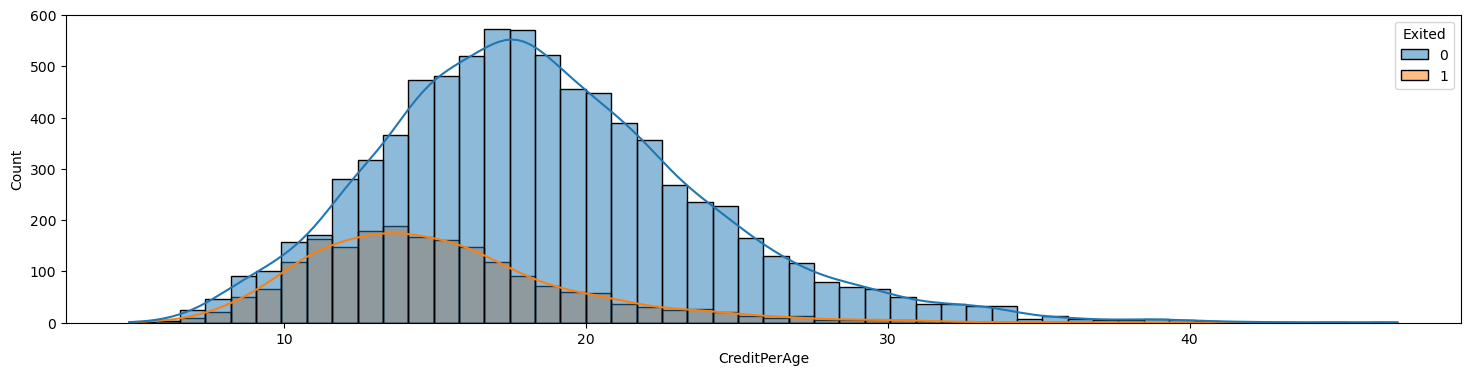

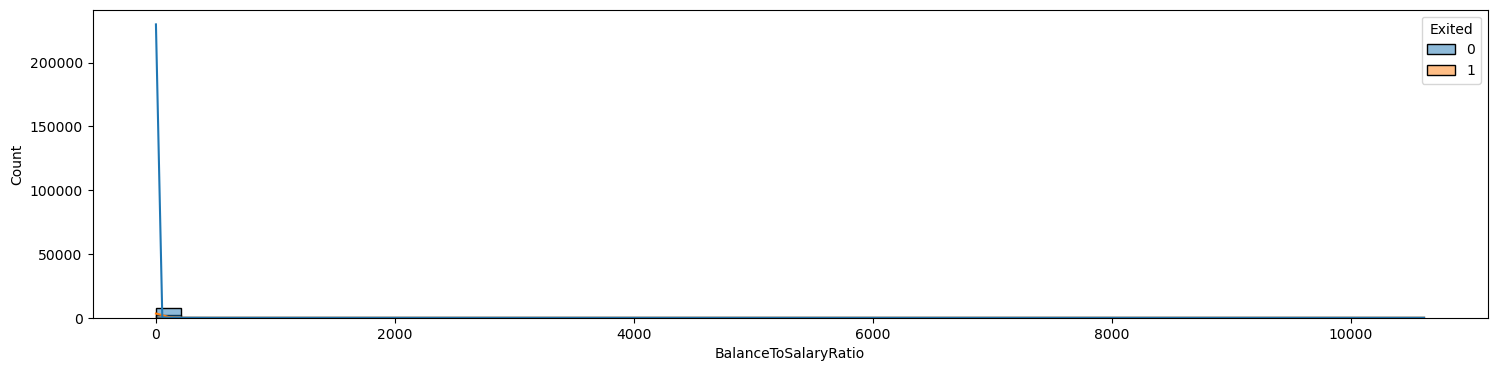

In [16]:
# Visualize continuous variables
for column in continuous_vars:
    fig, ax = plt.subplots(figsize=(18, 4))
    fig = sns.histplot(data=data, x=column, hue="Exited", bins=50, kde=True)
    plt.show()

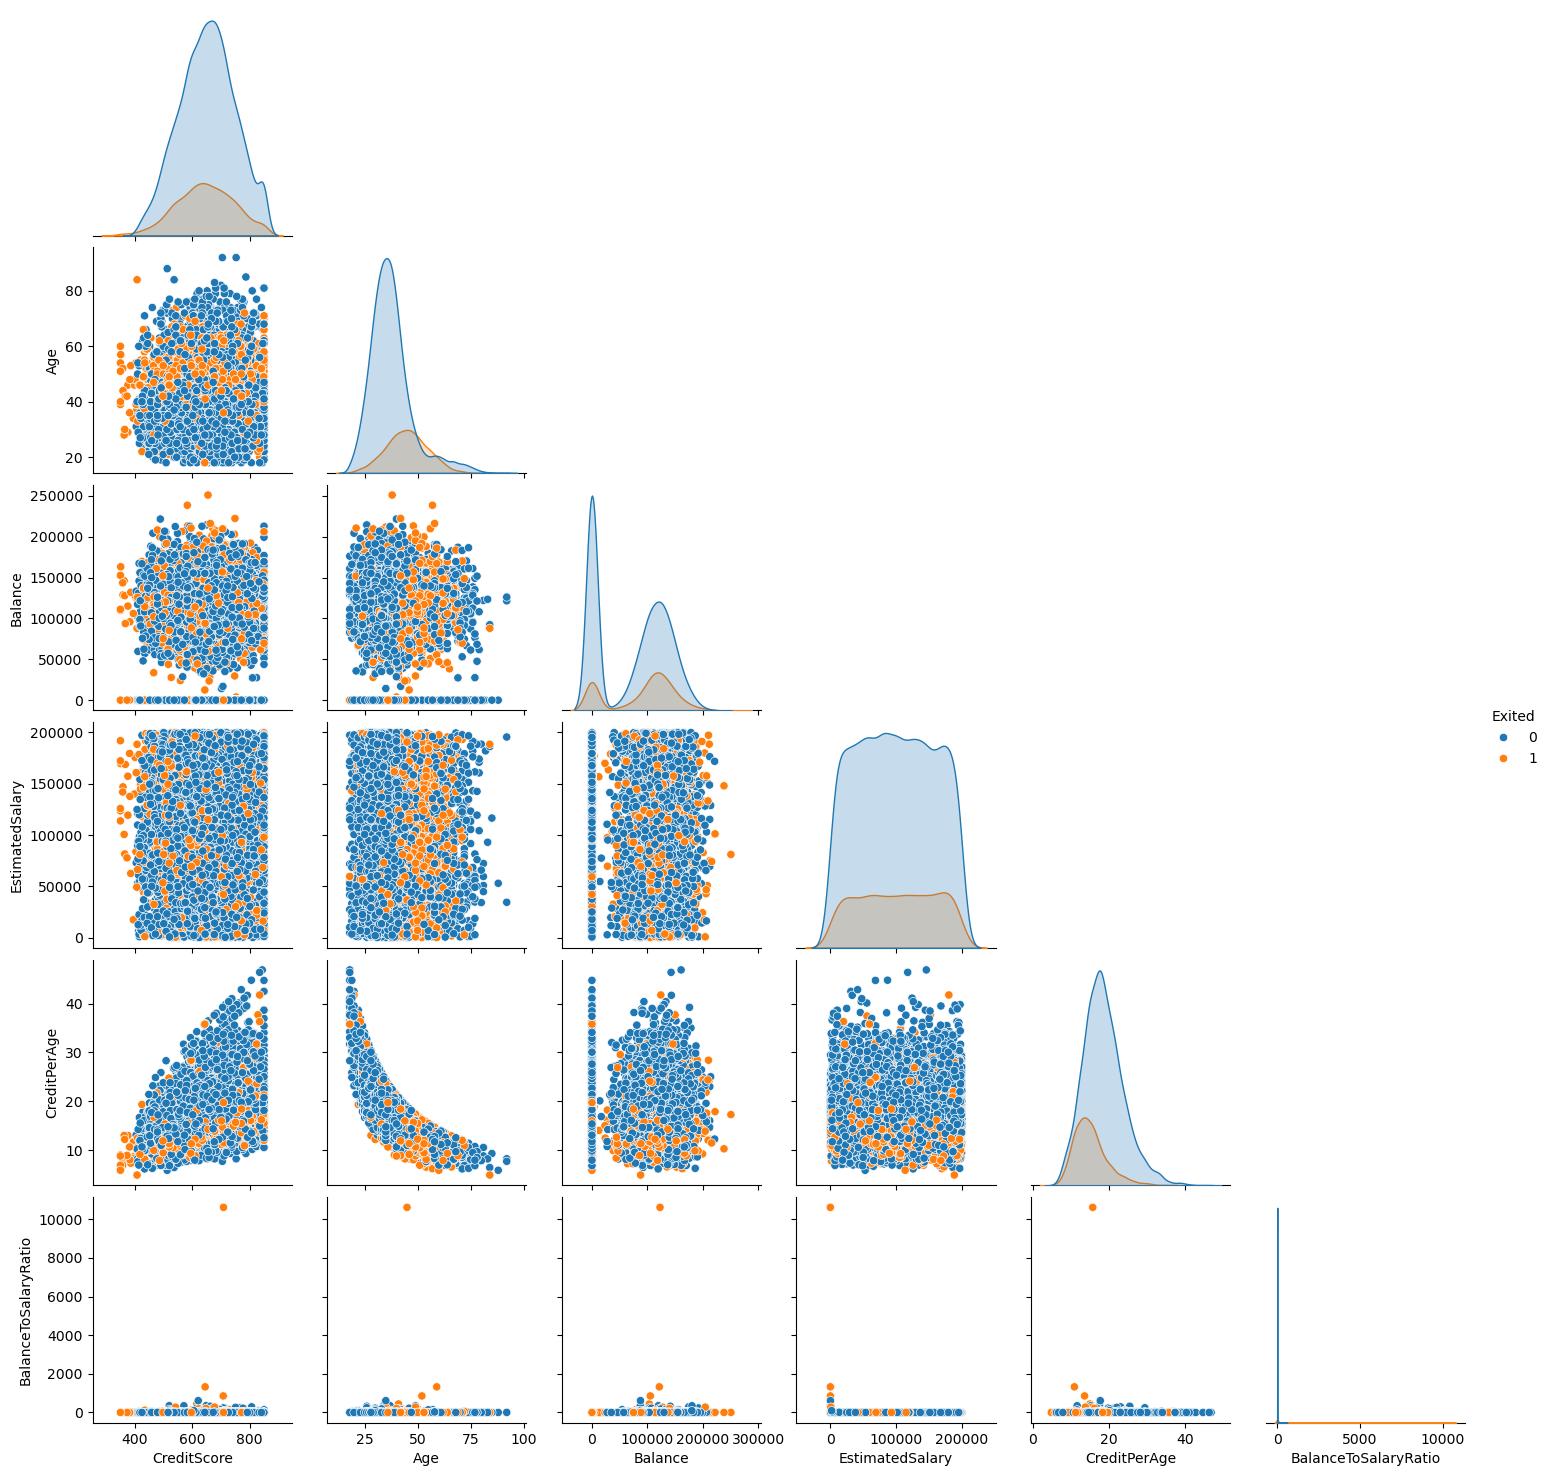

In [17]:
# Feature selection and correlation analysis
selected_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'CreditPerAge', 'BalanceToSalaryRatio', 'Exited']
df_selected = data[selected_features]
sns.pairplot(df_selected, hue="Exited", corner=True)
plt.show()

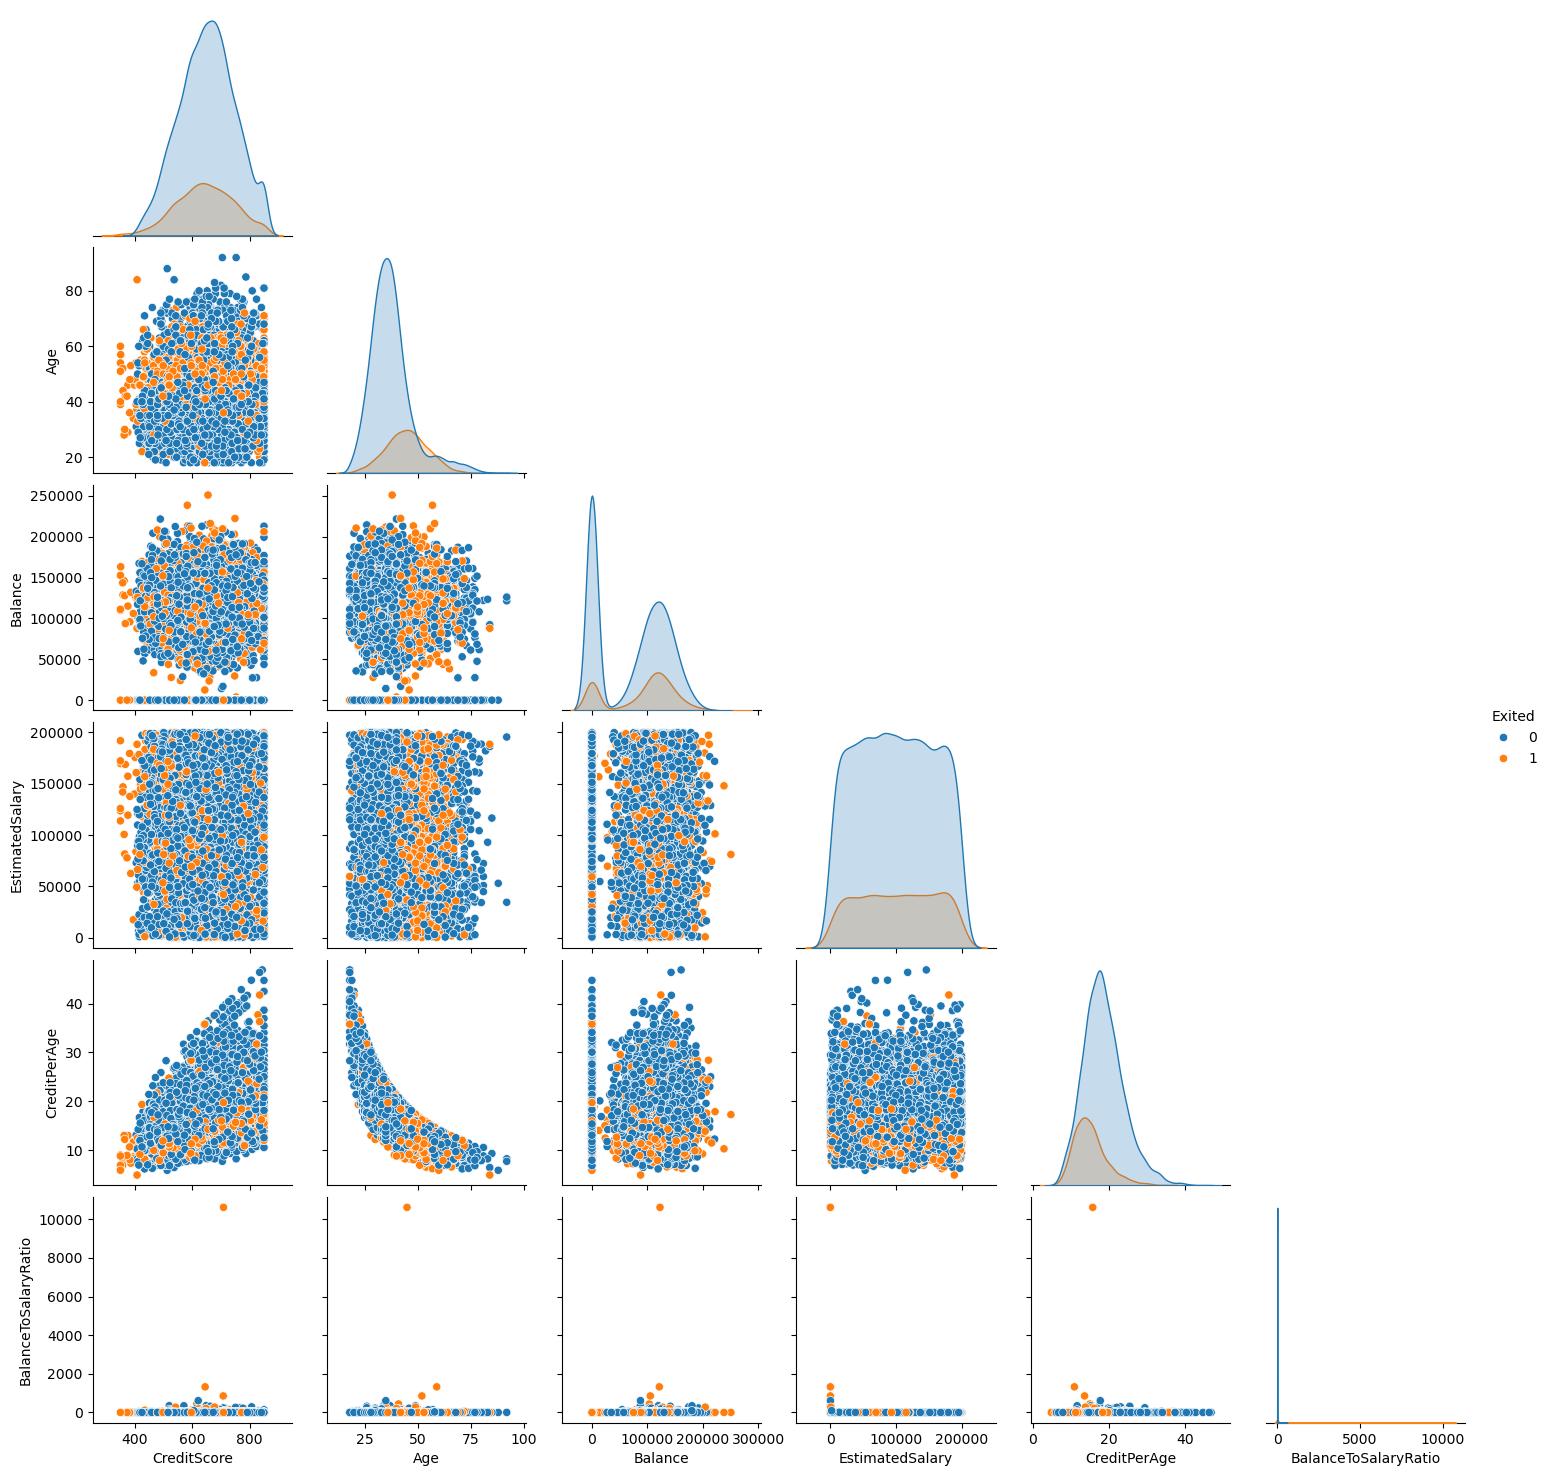

In [18]:
# Feature selection and correlation analysis
selected_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'CreditPerAge', 'BalanceToSalaryRatio', 'Exited']
df_selected = data[selected_features]
sns.pairplot(df_selected, hue="Exited", corner=True)
plt.show()

In [19]:
# Data preprocessing
X = data.drop([ 'CustomerID', 'Surname', 'Exited'], axis=1)
y = data['Exited']

In [20]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=['Geography', 'Gender', 'IsActiveMember', 'HasCrCard', 'NumOfProducts'])


In [21]:
X_encoded.head(2)

RowNumber  CreditScore  Age  Tenure   Balance  EstimatedSalary  \
0          1          619   42       2      0.00        101348.88   
1          2          608   41       1  83807.86        112542.58   

   CreditPerAge  BalanceToSalaryRatio  Geography_France  Geography_Germany  \
0     14.738095              0.000000              True              False   
1     14.829268              0.744677             False              False   

   ...  Gender_Female  Gender_Male  IsActiveMember_0  IsActiveMember_1  \
0  ...           True        False             False              True   
1  ...           True        False             False              True   

   HasCrCard_0  HasCrCard_1  NumOfProducts_1  NumOfProducts_2  \
0        False         True             True            False   
1         True        False             True            False   

   NumOfProducts_3  NumOfProducts_4  
0            False            False  
1            False            False  

[2 rows x 21 columns]

In [22]:
# AWS SageMaker Feature Store Integration
features = X_encoded.columns.tolist()

In [23]:
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.feature_store.feature_definition import FeatureTypeEnum, FeatureDefinition

In [24]:
from time import gmtime, strftime, sleep
# Create a unique name for your feature group
feature_group_name = "bank-churn-feature-group"+ strftime("%d-%H-%M-%S", gmtime())

In [25]:
print(feature_group_name)

bank-churn-feature-group04-09-45-05


In [26]:
# Create a FeatureGroup instance
churn_feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=feature_store_session)

In [27]:
X_encoded1=X_encoded.copy()

In [28]:
# List of boolean columns to convert
boolean_columns = ['Geography_France', 'Geography_Germany', 'Geography_Spain',
                   'Gender_Female', 'Gender_Male',
                   'IsActiveMember_0', 'IsActiveMember_1',
                   'HasCrCard_0', 'HasCrCard_1',
                   'NumOfProducts_1', 'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4']

# Convert boolean columns to 1 and 0
X_encoded1[boolean_columns] = X_encoded1[boolean_columns].astype(int)
X_encoded1.head(2)

RowNumber  CreditScore  Age  Tenure   Balance  EstimatedSalary  \
0          1          619   42       2      0.00        101348.88   
1          2          608   41       1  83807.86        112542.58   

   CreditPerAge  BalanceToSalaryRatio  Geography_France  Geography_Germany  \
0     14.738095              0.000000                 1                  0   
1     14.829268              0.744677                 0                  0   

   ...  Gender_Female  Gender_Male  IsActiveMember_0  IsActiveMember_1  \
0  ...              1            0                 0                 1   
1  ...              1            0                 0                 1   

   HasCrCard_0  HasCrCard_1  NumOfProducts_1  NumOfProducts_2  \
0            0            1                1                0   
1            1            0                1                0   

   NumOfProducts_3  NumOfProducts_4  
0                0                0  
1                0                0  

[2 rows x 21 columns]

In [29]:
event_time_feature_name = "event_time"

In [30]:
import time

current_time_sec = int(round(time.time()))
# Append EventTime feature
X_encoded1.loc[:, event_time_feature_name] = pd.Series([current_time_sec] * len(X_encoded1), dtype="float64")

In [31]:
# Load feature definitions to the feature group
churn_feature_group.load_feature_definitions(data_frame=X_encoded1)




[FeatureDefinition(feature_name='RowNumber', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='CreditScore', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='Age', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='Tenure', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='Balance', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='EstimatedSalary', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='CreditPerAge', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='BalanceToSalaryRatio', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 Feat

In [32]:
# Create the feature group
churn_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name='RowNumber',
    event_time_feature_name='event_time',  # Provide a dummy event time feature
    role_arn=role,
    enable_online_store=True
)


{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:994366592132:feature-group/bank-churn-feature-group04-09-45-05',
 'ResponseMetadata': {'RequestId': '23e671cc-76d5-44c0-b597-b467389dc1bd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '23e671cc-76d5-44c0-b597-b467389dc1bd',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '112',
   'date': 'Sun, 04 Feb 2024 09:45:06 GMT'},
  'RetryAttempts': 0}}

In [38]:
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

# Wait for feature group creation to complete
wait_for_feature_group_creation_complete(feature_group=churn_feature_group)

FeatureGroup bank-churn-feature-group04-09-45-05 successfully created.


In [39]:
# Ingest data into the feature group
churn_feature_group.ingest(data_frame=X_encoded1, max_workers=5, wait=True)

IngestionManagerPandas(feature_group_name='bank-churn-feature-group04-09-45-05', sagemaker_fs_runtime_client_config=<botocore.config.Config object at 0x7f3010205d50>, sagemaker_session=<sagemaker.session.Session object at 0x7f3010e33d90>, max_workers=5, max_processes=1, profile_name=None, _async_result=<multiprocess.pool.MapResult object at 0x7f2ff49713c0>, _processing_pool=<pool ProcessPool(ncpus=1)>, _failed_indices=[])

In [40]:
# Display Hive DDL statements for the feature group
print(churn_feature_group.as_hive_ddl())


CREATE EXTERNAL TABLE IF NOT EXISTS sagemaker_featurestore.bank-churn-feature-group04-09-45-05 (
  RowNumber INT
  CreditScore INT
  Age INT
  Tenure INT
  Balance FLOAT
  EstimatedSalary FLOAT
  CreditPerAge FLOAT
  BalanceToSalaryRatio FLOAT
  Geography_France INT
  Geography_Germany INT
  Geography_Spain INT
  Gender_Female INT
  Gender_Male INT
  IsActiveMember_0 INT
  IsActiveMember_1 INT
  HasCrCard_0 INT
  HasCrCard_1 INT
  NumOfProducts_1 INT
  NumOfProducts_2 INT
  NumOfProducts_3 INT
  NumOfProducts_4 INT
  event_time FLOAT
  write_time TIMESTAMP
  event_time TIMESTAMP
  is_deleted BOOLEAN
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
  STORED AS
  INPUTFORMAT 'parquet.hive.DeprecatedParquetInputFormat'
  OUTPUTFORMAT 'parquet.hive.DeprecatedParquetOutputFormat'
LOCATION 's3://sagemaker-us-east-1-994366592132/sagemaker-featurestore-bankchurn/994366592132/sagemaker/us-east-1/offline-store/bank-churn-feature-group04-09-45-05-1707039906/data'


In [41]:
# Query Feature Group with Athena
churn_query = churn_feature_group.athena_query()

query_string = 'SELECT * FROM "' + churn_query.table_name + '"'

churn_query.run(query_string=query_string, output_location="s3://{}/{}/query_results/".format(default_s3_bucket_name, prefix))
churn_query.wait()
query_result = churn_query.as_dataframe()

# Display the query result using df.head()
print(query_result.head())

   rownumber  creditscore  age  tenure    balance  estimatedsalary  \
0          8          376   29       4  115046.74        119346.88   
1       6018          487   34       2   96019.50          9085.00   
2       2036          583   44       8       0.00         27431.62   
3       4051          803   41       9  137742.90        166957.82   
4       6056          479   23       9  123575.51         95148.28   

   creditperage  balancetosalaryratio  geography_france  geography_germany  \
0     12.965517              0.963969                 0                  1   
1     14.323529             10.569015                 1                  0   
2     13.250000              0.000000                 1                  0   
3     19.585366              0.825016                 0                  1   
4     20.826087              1.298768                 0                  1   

   ...  hascrcard_0  hascrcard_1  numofproducts_1  numofproducts_2  \
0  ...            0            1        